## Dependencies

In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
sns.set_style("darkgrid")

## Dataset

In [56]:
col_names = np.array(['season','age','child_diseases','accident',
                      'surgical_intervention','high_fevers', 
                      'alcohol', 'smoking','hrs_sitting','diagnosis'])

data = pd.read_csv("data/fertility_Diagnosis.csv", header=None, names=col_names)
data.dropna(inplace = True)

print("Data dimensionality", data.shape)
data.head()

Data dimensionality (100, 10)


,season,age,child_diseases,accident,surgical_intervention,high_fevers,alcohol,smoking,hrs_sitting,diagnosis
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,N
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,O
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,N
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,N
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,O


## Basic EDA

In [57]:
# Encode the diagnosis to binary form
# Diagnosis: normal (N), altered (O)	
diagnosis = data.iloc[:,-1]

label_encoder = LabelEncoder()
target = label_encoder.fit_transform(diagnosis)
data['diagnosis'] = target

# Review the encoded lables
encoded_compr = pd.DataFrame({'diagnosis': diagnosis, 'encoded_label': target})
encoded_compr.head()

,diagnosis,encoded_label
0,N,0
1,O,1
2,N,0
3,N,0
4,O,1


<Axes: title={'center': 'Distribution of target values'}, xlabel='Diagnosis', ylabel='Frequency'>

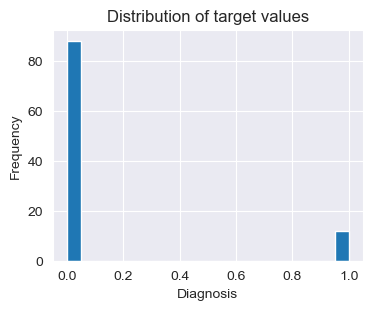

In [58]:
# Distribution of target
distr = pd.DataFrame(target)
distr.plot.hist(bins=20, 
                figsize=(4,3), 
                xlabel='Diagnosis', 
                legend=False, 
                title='Distribution of target values')

<Axes: >

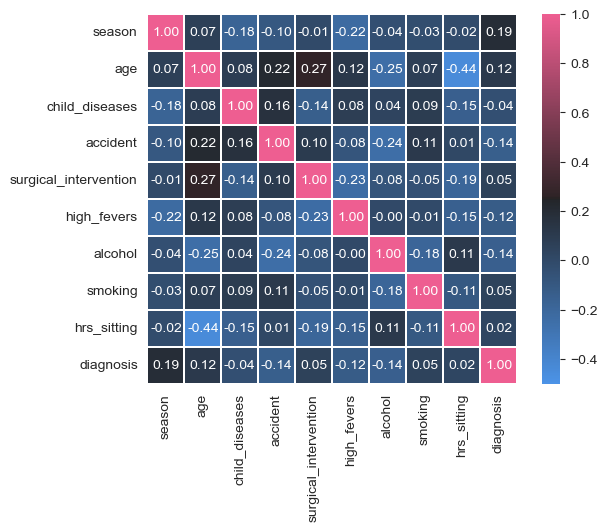

In [59]:
corr = data.corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, annot=True, fmt='.2f',  cmap=cmap, square=True, linewidths=.2)

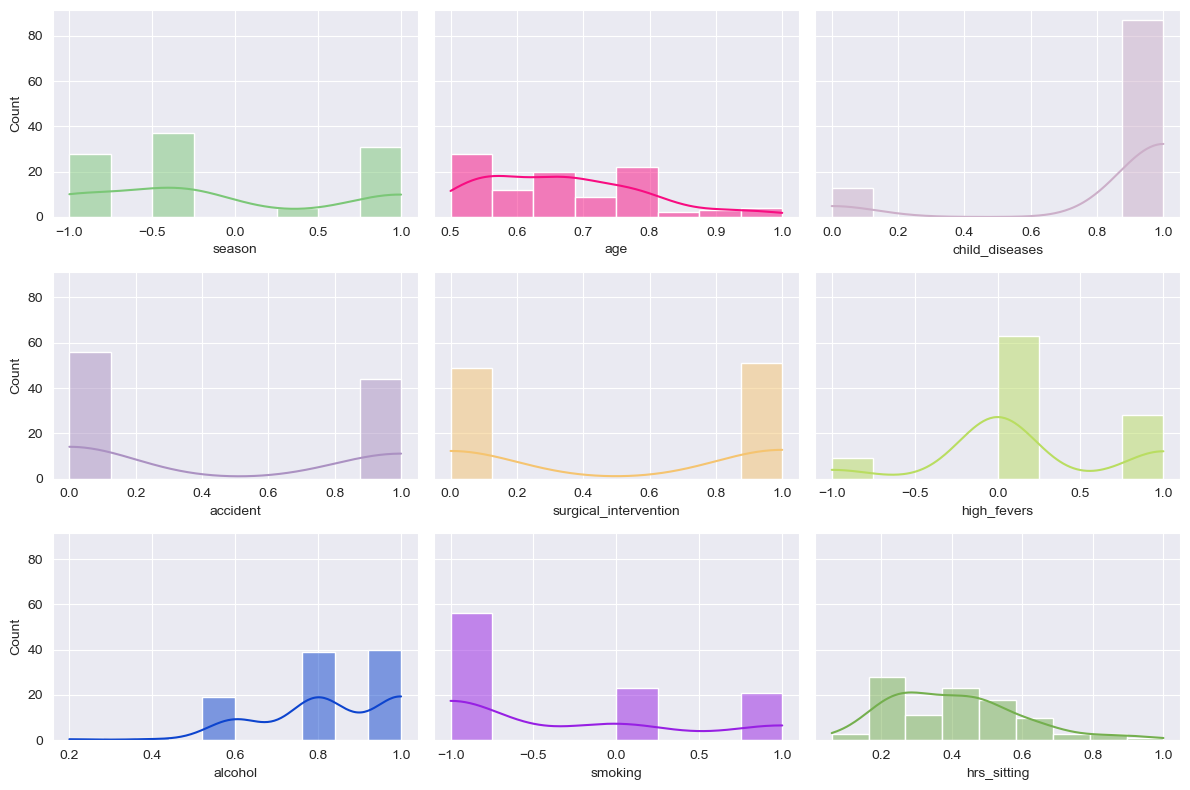

In [60]:
colors = np.random.rand(data.shape[1]-1, 3)  
fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharey=True)
axes = axes.flatten()

for i in range(data.shape[1]-1):
    sns.histplot(data.iloc[:,i], ax=axes[i], kde=True, color=colors[i])

plt.tight_layout()
plt.show()


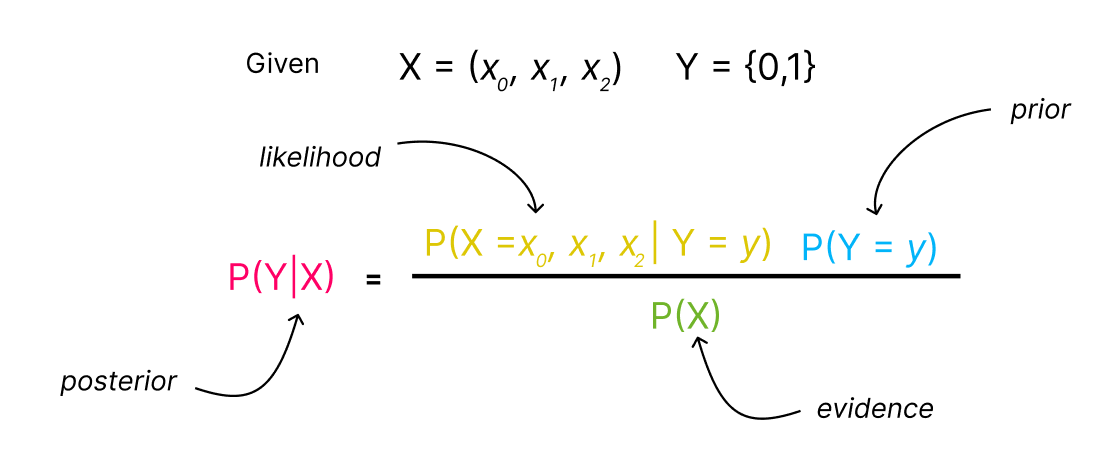

## Calculate P(Y=y) for all possible y

In [61]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

## Approach 1: Calculate P(X=x|Y=y) using Gaussian dist.

In [62]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [63]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

## Test Gaussian model

In [65]:
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

# TODO: F1 is 0

[[14  4]
 [ 2  0]]
0.0


what does means 0? false negative ... and what about 4? false positive

## Convert continuous features to Categorical features

In [ ]:
data["cat_mean_radius"] = pd.cut(data["mean_radius"].values, bins = 3, labels = [0,1,2])
data["cat_mean_texture"] = pd.cut(data["mean_texture"].values, bins = 3, labels = [0,1,2])
data["cat_mean_smoothness"] = pd.cut(data["mean_smoothness"].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=["mean_radius", "mean_texture", "mean_smoothness"])
data = data[["cat_mean_radius",	"cat_mean_texture",	"cat_mean_smoothness", "diagnosis"]]
data.head(10)

KeyError: 'mean_radius'

## Approach 2: Calculate P(X=x|Y=y) categorically

In [ ]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [ ]:
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

## Test Categorical model

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))